In [2]:

from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import tensorflow as tf
import numpy as np 
import matplotlib 
import os
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization , ReLU, LeakyReLU, Dropout,Reshape
from keras.optimizers import Adam
import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
def discriminator():
	model = Sequential()
	model.add(Conv2D(8, (3,3) , strides= (2,2), padding= 'same',input_shape = (256,256,3)))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))

#128*128*8
	
	model.add(Conv2D(16, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization( momentum= 0.7))
	model.add(LeakyReLU(0.2))
	#model.add(Dropout(0.3))
#64*64*16

	model.add(Conv2D(32, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	#model.add(Dropout(0.3))
#32*32*32

	model.add(Conv2D(64, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#16*16*64

	model.add(Conv2D(128, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	#model.add(Dropout(0.3))
#8*8*128
	model.add(Conv2D(256, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#4*4*256
	model.add(Flatten())
	model.add(Dense(128))
	model.add(LeakyReLU(0.2))


	model.add(Dense(1,activation ='sigmoid'))
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)
	model.compile(optimizer= optimus, loss = 'binary_crossentropy',metrics=['accuracy'])

	return model

In [0]:
def generator(latent_dim):
  
	model = Sequential()
	model.add(Dense((4096),input_dim = latent_dim))
	model.add(Reshape((1,1,4096)))

	model.add(Conv2DTranspose(512, (4,4) , strides=(2,2), padding='same'))
	model.add(ReLU())
#2*2*512
	model.add(Conv2DTranspose(256,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	#model.add(Dropout(0.3))
#4*4*256
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	#model.add(Dropout(0.3))
#8*8*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	#model.add(Dropout(0.3))
#16*16*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	#model.add(Dropout(0.3))
#32*32*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	#model.add(Dropout(0.3))
#64*64*128	
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#128*128*128

	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	#model.add(Dropout(0.3))

#256*256*4
	model.add(Conv2D(3,(3,3),activation= 'tanh',padding = 'same'))
	optimus = Adam(learning_rate=0.0002,beta_1=0.5)

	model.compile(optimizer=optimus , loss = 'binary_crossentropy')

	return model

In [0]:
def gan(g_model,d_model):

	d_model.trainable = False
	model =Sequential()
	model.add(g_model)
	model.add(d_model)
	optimus = Adam(learning_rate=0.0002,beta_1=0.5)
	model.compile(optimizer=optimus,loss='binary_crossentropy')
	return model

In [0]:
def load_real_data(xsam):
    
    x= np.array(xsam).reshape(-1,256,256,3)
    x = (x-127.5)/127.5
    print(x.shape)
    return x

In [0]:
def generate_real_samples(dataset , n_samples):

	for i in range (n_samples):
		index = np.random.randint(0 , dataset.shape[0] , n_samples)

		image = dataset[index]
		y = np.ones((n_samples,1))

		return image,y

In [0]:
def generate_latent_sample(laten_dim,n_samples):
	
	x = np.random.randn(laten_dim*n_samples)
	x = x.reshape(n_samples,laten_dim)

	return x

In [0]:

def generate_fake_samples(g_model, latent_dim,n_samples):
	
	x = generate_latent_sample(latent_dim,n_samples)
	x = g_model.predict(x)
	y = np.zeros((n_samples,1))

	return x,y

In [0]:
def save_plot(examples ,epoch , n = 3):
	examples = (examples+1) / 2.0

	for i in range(n*n):
		pyplot.subplot(3,3,1+i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%0.3d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [0]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples = 132):

	x_real ,y_real = generate_real_samples(dataset,n_samples)
	_,acc_real = d_model.evaluate(x_real,y_real)

	x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
	_,acc_fake = d_model.evaluate(x_fake,y_fake)

	print(('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)))
	save_plot(x_fake,epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [0]:
def train(g_model,d_model,gan_model, dataset ,latent_dim, n_epoch = 500, n_batch = 16):
	batch_per_epoch = int(dataset.shape[0]/n_batch)
	batch = int(n_batch/2)

	for i in range(n_epoch):
		for j in range (batch_per_epoch):

			x_real,y_real = generate_real_samples(dataset,batch)

			d_model_loss1,_ = d_model.train_on_batch(x_real,y_real)

			x_fake ,y_fake = generate_fake_samples(g_model,latent_dim,batch)

			d_model_loss2,_ =d_model.train_on_batch(x_fake,y_fake)

			x_gan = generate_latent_sample(latent_dim, n_batch)
			y_gan = np.ones((n_batch,1))

			g_model_loss = gan_model.train_on_batch(x_gan,y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f'% 
                  (i+1, j+1, batch_per_epoch, d_model_loss1, d_model_loss2, g_model_loss))
		if (i+1) % 25 ==0 :
			summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [0]:
xsam = []
CATEGORIES = [""]
training_data = []
IMG_SIZE = (256)

data_dir = "/content/drive/My Drive/images"

In [15]:
# for category in CATEGORIES:

path = os.path.join(data_dir) 

for img in tqdm(os.listdir(path)):
  img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_UNCHANGED)  # convert to array
  img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB )
  new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))  # resize to normalize data size
  training_data.append([new_array])  # add this to our training_data


100%|██████████| 132/132 [01:39<00:00,  1.33it/s]


In [16]:
print(img_array)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [17]:
for features in training_data:
  
  xsam.append(features)
#  #   return xsam
print(np.array(xsam).shape)
print(np.array(training_data).shape)

(132, 1, 256, 256, 3)
(132, 1, 256, 256, 3)


In [18]:
latent_dim = 4096
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model,d_model)
d_model.summary()
g_model.summary()
print(np.array(training_data).shape)

dataset = load_real_data(xsam)
train(g_model,d_model,gan_model,dataset,latent_dim)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)       

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/8, d1=1.207, d2=2.296 g=0.454
>1, 2/8, d1=0.218, d2=1.269 g=0.782
>1, 3/8, d1=0.707, d2=0.977 g=0.938
>1, 4/8, d1=0.538, d2=0.825 g=0.910
>1, 5/8, d1=0.706, d2=0.883 g=0.911
>1, 6/8, d1=1.362, d2=0.347 g=0.206
>1, 7/8, d1=0.513, d2=0.939 g=0.175
>1, 8/8, d1=0.237, d2=0.609 g=0.206
>2, 1/8, d1=0.943, d2=0.863 g=0.223
>2, 2/8, d1=0.989, d2=0.891 g=0.160
>2, 3/8, d1=1.718, d2=2.085 g=0.134
>2, 4/8, d1=0.532, d2=1.660 g=0.697
>2, 5/8, d1=1.366, d2=1.244 g=0.641
>2, 6/8, d1=1.752, d2=1.472 g=0.571
>2, 7/8, d1=1.656, d2=1.874 g=0.809
>2, 8/8, d1=1.262, d2=2.103 g=1.140
>3, 1/8, d1=1.539, d2=1.432 g=1.471
>3, 2/8, d1=1.942, d2=1.835 g=1.116
>3, 3/8, d1=1.663, d2=1.898 g=0.887
>3, 4/8, d1=1.484, d2=1.685 g=1.161
>3, 5/8, d1=0.989, d2=1.424 g=1.093
>3, 6/8, d1=1.236, d2=1.351 g=0.990
>3, 7/8, d1=1.555, d2=1.210 g=1.016
>3, 8/8, d1=1.520, d2=1.704 g=0.815
>4, 1/8, d1=1.114, d2=1.449 g=0.906
>4, 2/8, d1=1.160, d2=1.166 g=1.214
>4, 3/8, d1=1.319, d2=1.278 g=1.006
>4, 4/8, d1=1.463, d2=1.249 

Generated Image


<function matplotlib.pyplot.show>

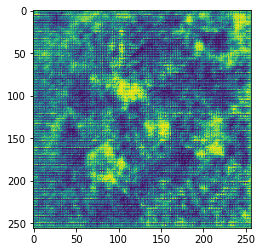

In [29]:
from keras.models import load_model

model = load_model('generator_model_500.h5')
vector = np.asarray([[1.0 for _ in range(4096)]])

x= model.predict(vector)
x = (x+1)/2
print("Generated Image")
pyplot.imshow(x[0,:,:,0])
pyplot.show